In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from utils import *
from unet import *

c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\ten

In [2]:
# from google.colab import files

# file = files.upload()

In [3]:
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list

In [4]:
# !kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

In [5]:
# !unzip "/content/lgg-mri-segmentation.zip"

In [6]:
# Setting Size Parameters of images
img_width = 256
img_height = 256

## Loading Image and Mask Paths

In [9]:
image_filenames_train = []

# Creating a list of all the images containing the word mask
# mask_files = glob('/content/lgg-mri-segmentation/kaggle_3m/*/*_mask*') # kaggle dir
mask_files = glob('lgg-mri-segmentation/kaggle_3m/*/*_mask*')
for i in mask_files:
    image_filenames_train.append(i.replace("_mask", ""))

print(image_filenames_train[:10])
len(image_filenames_train)

['lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10.tif', 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11.tif', 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12.tif', 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_13.tif', 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_14.tif', 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_15.tif', 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_16.tif', 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_17.tif', 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_18.tif', 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_19.tif']


3929

## Plotting few images and masks

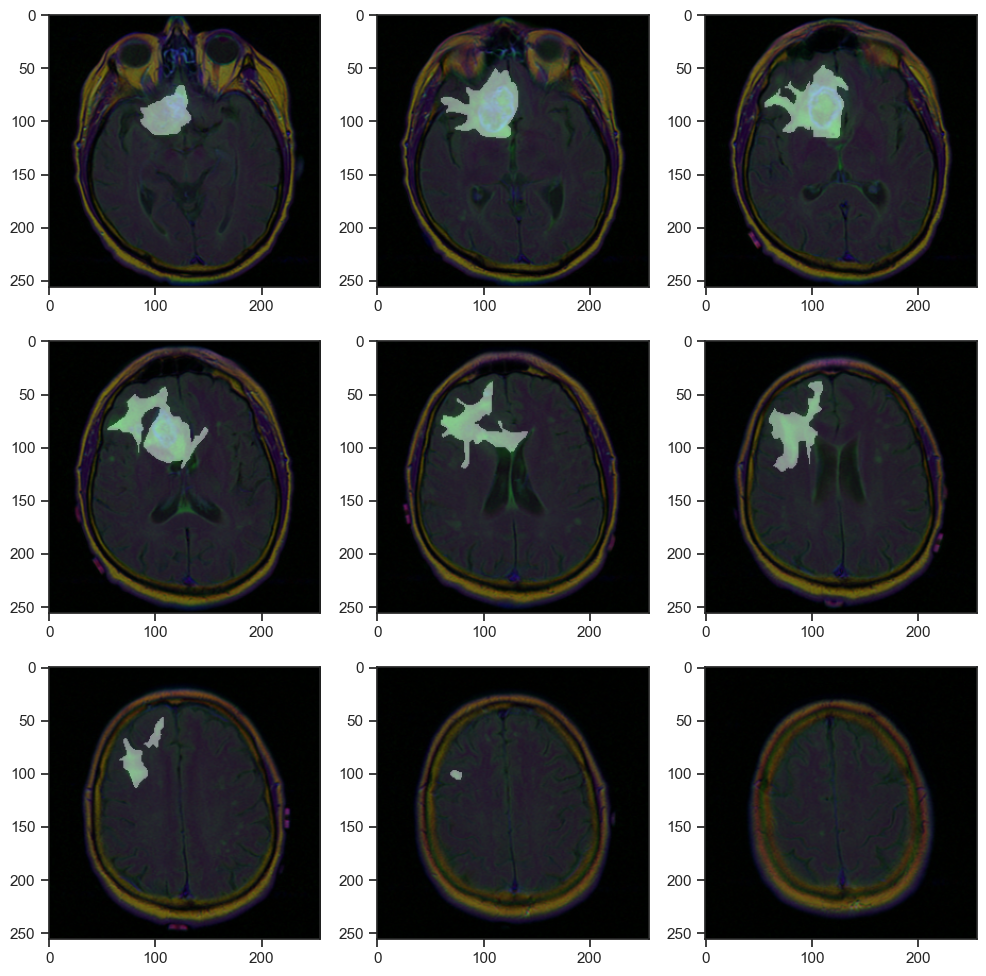

In [10]:
plot_from_img_path(3,3, image_filenames_train, mask_files)

## Create Dataframe and split data on train set, validation set and test set

In [11]:
df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, "mask" : mask_files})

In [12]:
df_train, df_test = train_test_split(df, test_size=0.1) # Test Size - 0.1 means 10%

# Further split this into val and test
df_train, df_val = train_test_split(df_train, test_size=0.2)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(2828, 2)
(393, 2)
(708, 2)


## **Data generator, data augmentation and adjust data**

In [13]:
# Referring from https://github.com/zhixuhao/unet/blob/master/data.py

def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)

    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [14]:
''' After mask Normalization if the value is <= 0.5 then that Mask
will be considered a complete black one and does not have any Tumor '''
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

In [15]:
EPOCHS = 100
BATCH_SIZE = 32
learning_rate = 1e-4
smooth = 100

In [16]:
model = unet()
model.summary

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


<bound method Network.summary of <tensorflow.python.keras.engine.training.Model object at 0x000001DB49916448>>

In [17]:
train_generator_param = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_param,
                                target_size=(img_height, img_width))

test_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(img_height, img_width))

model = unet(input_size=(img_height, img_width, 3))



decay_rate = learning_rate / EPOCHS

opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=decay_rate, amsgrad=False)

model.compile(optimizer=opt, loss=dice_coefficient_loss, metrics=["binary_accuracy", iou, dice_coefficients])

callbacks = [ModelCheckpoint('unet.keras', verbose=1, save_best_only=True)]
history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) // BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data = test_gen,
                    validation_steps=len(df_val) // BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.


ResourceExhaustedError: OOM when allocating tensor with shape[3,3,1024,1024] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node conv2d_9/kernel/Initializer/random_uniform/RandomUniform (defined at d:\My Projects\Brain Tumer Segmentation\unet.py:68) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Original stack trace for 'conv2d_9/kernel/Initializer/random_uniform/RandomUniform':
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
    app.start()
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
    self.io_loop.start()
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\asyncio\base_events.py", line 541, in run_forever
    self._run_once()
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\asyncio\base_events.py", line 1786, in _run_once
    handle._run()
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
    await self.process_one()
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
    await dispatch(*args)
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
    await result
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
    reply_content = await reply_content
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py", line 387, in do_execute
    cell_id=cell_id,
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
    return super().run_cell(*args, **kwargs)
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 2975, in run_cell
    raw_cell, store_history, silent, shell_futures, cell_id
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 3029, in _run_cell
    return runner(coro)
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
    coro.send(None)
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 3257, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 3472, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 3552, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\rebuytech\AppData\Local\Temp\ipykernel_22708\1166116476.py", line 1, in <module>
    model = unet()
  File "d:\My Projects\Brain Tumer Segmentation\unet.py", line 68, in unet
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 591, in __call__
    self._maybe_build(inputs)
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 1881, in _maybe_build
    self.build(input_shapes)
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\layers\convolutional.py", line 165, in build
    dtype=self.dtype)
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 384, in add_weight
    aggregation=aggregation)
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\training\tracking\base.py", line 663, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\engine\base_layer_utils.py", line 155, in make_variable
    shape=variable_shape if variable_shape.rank else None)
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\ops\variables.py", line 259, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\ops\variables.py", line 220, in _variable_v1_call
    shape=shape)
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\ops\variables.py", line 198, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2495, in default_variable_creator
    shape=shape)
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\ops\variables.py", line 263, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py", line 460, in __init__
    shape=shape)
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py", line 604, in _init_from_args
    initial_value() if init_from_fn else initial_value,
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\engine\base_layer_utils.py", line 135, in <lambda>
    init_val = lambda: initializer(shape, dtype=dtype)
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\ops\init_ops.py", line 533, in __call__
    shape, -limit, limit, dtype, seed=self.seed)
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\ops\random_ops.py", line 247, in random_uniform
    rnd = gen_random_ops.random_uniform(shape, dtype, seed=seed1, seed2=seed2)
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\ops\gen_random_ops.py", line 858, in random_uniform
    name=name)
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\ops.py", line 3616, in create_op
    op_def=op_def)
  File "c:\Users\rebuytech\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
import pprint

pprint.pprint(history.history)

In [ ]:
history_post_training = history.history

train_dice_coeff_list = history_post_training['dice_coefficients']
test_dice_coeff_list = history_post_training['val_dice_coefficients']

train_jaccard_list = history_post_training['iou']
test_jaccard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list, 'b-')
plt.plot(train_loss_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph', fontsize=12)

plt.figure(2)
plt.plot(train_dice_coeff_list, 'b-')
plt.plot(test_dice_coeff_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy graph', fontsize=12)
plt.show()

In [ ]:
model = load_model('unet.hdf5', custom_objects={'dice_coefficient_loss': dice_coefficient_loss, 'iou': iou, 'dice_coefficients': dice_coefficients  } )

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(img_height, img_width)  )

results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE )

print('Test Loss ', results[0] )
print('Test IoU ', results[1] )
print('Test Dice Coefficient ', results[2] )


## Plotting Predicted Masks Segmentation results from the Test Image set

In [ ]:
for i in range(20):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filenames_train'].iloc[index])
    img = cv2.resize(img, (img_height, img_width))
    img = img/255
    # print(imgs.shape) (256, 256 , 3)
    img = img[np.newaxis, :, :, : ]
    # print(img.shape) # (1, 256, 256, 3)

    predicted_img = model.predict(img)

    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.show()



In [ ]:
import os
print(os.getcwd())